# Implementing Locally Connected Layers

This notebook contains the code for our group's implementation of locally connected layers using PyTorch. Our goal is to successfully implement locally connected layers which would only allow units to take inputs from a small region around itself. In general, this type of layer allows the network to learn different types of features for different regions of the input.

After we finish building the relevant classes, we will look to integrate them into vanilla Recurrent Neural Networks (RNN). Specifically, we hope to accomplish this by replacing fully-connected layers in RNNs with locally connected layers.

Note that this notebook only contains the implementation of the locally connected layers and testing its feasibility on a toy dataset to make sure our approach is free of bugs. Subsequent evaluations on larger syntactic datasets will be done through other Python scripts. 


In [ ]:
## External Libararies
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

### Data Loading
First, we use the toy dataset from HW4 as a starting point in order to test the feasibility of the locally connected layers

In [ ]:
## Spectify Path to Provided Data Here
DATA_PATH = 'data.npy'

## Load Data and Check Dimensionality
data = np.load(DATA_PATH)
Y = data[:,2]
X = data[:,0:2]
print("Y:", Y.shape)
print("X:", X.shape)

## Polygon Boundaries
p = [[[500, 1000], [300, 800], [400, 600], [600, 600], [700, 800]],
     [[500, 600], [100, 400], [300, 200], [700, 200], [900, 400]]]
p = np.asarray(p)
p0 = p[0]
p1 = p[1]

Y: (60000,)
X: (60000, 2)


### Visualization Code

Do not touch any of the visualization code below.

In [ ]:
## Helper code for visualisation (No Need to Touch)
def visualize_polygons(p0, p1):
    """
    
    """
    fig, ax = plt.subplots()
    patches = []
    polygon1 = Polygon(p0, True)
    polygon2 = Polygon(p1, True)
    patches.append(polygon1)
    patches.append(polygon2)
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    ax.add_collection(p)
    ax.autoscale_view()
    plt.show()

def visualize_datapoints(X, Y):
    """
    
    """
    assert(X.shape[0] == Y.shape[0])
    fig, ax = plt.subplots()
    npts = 60000
    col = np.where(Y[:npts]==1,'m','b')
    col = np.reshape(col, (col.shape[0],))
    x1 = X[:npts][:,0]
    x2 = X[:npts][:,1]
    ax.scatter(x1, x2, s=0.5, c=col, zorder=1)
    plt.show()

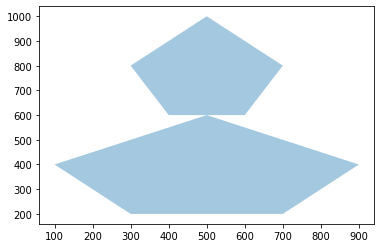

In [ ]:
visualize_polygons(p0,p1)

### Singular Locally Connected Layer

We implement a LocallyConnectedLayer1d class which acts as a singular locally connected layer for a 1-dimensional input vector.

Our original intuition was to represent locally connected layers as a sparse weight matrix with the dimensionality of output_dim x input_dim. To make this more efficient, we instead model this using a dense matrix of size output_dim x kernel_size. Additionally, padding is implemented to ensure that the matrix dimensionality is as expected. 



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LocallyConnectedLayer1d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding=True, bias=False):
      """
      Defines one locally connected layer for one dimensional vector input.
      NOTE: This model only takes one-dimensional inputs. Batched inputs are also fine.

      input_dim: column size of weight matrix
      output_dim: row size of weight matrix
      kernel_size: number of local connections per parameter
      stride: number of strides of local connections, CANNOT BE ZERO
      padding: whether or not to zero pad
      bias: whether or not to have a bias term
      """
      super(LocallyConnectedLayer1d, self).__init__()
      # Goal is to create sparse locally connected weight matrix size output_dim x input_dim
      # Instead of doing that, dense matrix of size output_dim x kernel_size is equivalent
      # Given special operation substitute for matrix multiplication
      self.weight = nn.Parameter(
          torch.randn(output_dim, kernel_size)
      )
      if bias:
          self.bias = nn.Parameter(
              torch.randn(output_dim)
          )
      else:
          self.register_parameter('bias', None)
      self.kernel_size = kernel_size
      self.stride = stride

      if padding == True:
        # Compute the amount needed to pad input vector with 0s by
        # In order to make the unfolding operation result in row dim same as output_dim
        pad_size = (stride * (output_dim - 1)) + kernel_size - input_dim
        self.input_dim = input_dim + pad_size
        self.pad = True
      else:
        # Alternative to padding is to repeat last row of unfolded input matrix
        # Until number of rows is the same as output_dim
        resulting_dim = ((input_dim - kernel_size) / stride) + 1
        self.extra_dim = output_dim - resulting_dim
        self.pad = False


    def forward(self, x):
      k = self.kernel_size
      s = self.stride

      instance_dim = len(x.size())-1

      # Executes padding strategy to resize input vector x for matrix multiplication shortcut
      if self.pad:
        pad_size = self.input_dim - x.size()[instance_dim]
        # If pad size is positive need to pad, else need to remove data
        if pad_size >= 0:
          # How much to pad each dimension
          pad = (0, pad_size) #TODO this might be wrong, need to check this works as intended
          x = F.pad(x, pad=pad)
          # Unfold x by striding over the input features by kernel size and stride
          x = x.unfold(instance_dim, k, s)
        else: # If pad size is negative, need to remove rows from unfolded x
          x = x.unfold(instance_dim, k, s)
          if instance_dim == 0:
            x = x[:pad_size]
          else:
            x = x[:,:pad_size,:]
            
      else: # If not padding, need to duplicate last unfolded row, this is the uglier method
        x = x.unfold(instance_dim, k, s)
        for i in self.extra_dim:
          if instance_dim == 0:
            x = torch.cat((x, x[-1]), dim=instance_dim)
          else:
            x = torch.cat((x, x[:,-1,:]), dim=instance_dim)

      # Do elementwise multiplication of x and weights and then sum across the rows
      # NOTE: this is the same as doing matrix multiplication with sparse weight matrix, but faster
      out = torch.sum(x * self.weight, dim=instance_dim+1)
      if self.bias is not None:
          out += self.bias
      return out

### Stacked Locally Connected Layers
In order to integrate locally connected layers into vanilla RNNs, we stack singular layers together in the class below.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
from collections import OrderedDict

class LocallyConnectedMLP(nn.Module):
    def __init__(self, 
                 n_layers: int, 
                 activation_fn: nn.Module,
                 input_dim: List[int], 
                 output_dim: List[int], 
                 kernel_size: List[int], 
                 stride: List[int],
                 conv: bool = False, 
                 padding: bool = True, 
                 bias: bool = True):
      """
      Creates multiple locally connected layers. For the arguments defining
      locally connected layers, need to pass in a list of integers, one for each
      layer.
      Locally connected layers are highly sensitive to gradient flow. Need to be
      careful about not making kernel size too small or too large, and need to 
      visualize what the network will look like, making sure that stride doesn't
      make most of the nodes in the layer not connected to anything.
      There is an option to add a convolution layer before the locally connected
      layers, a method employed by a few reference papers to smooth any location
      information.
      NOTE: if conv is True, then n_layers includes conv layer.
      """
      super(LocallyConnectedMLP, self).__init__()

      lcstack = []

      i=0
      if conv:
        conv_name = 'conv1'
        if kernel_size[0] % 2 == 0:
          kernel_size[0]-=1
        p = kernel_size[0] // 2
        lcstack.append((conv_name, nn.Conv1d(input_dim[0], output_dim[0], kernel_size[0], stride[0], p)))
        i = 1
      
      for j in range(i,n_layers-1):
        args = []
        for arg in [input_dim, output_dim, kernel_size, stride]:
            args.append(arg[j])
        lc = LocallyConnectedLayer1d(args[0], args[1], args[2], args[3], padding, bias)
        layer_name = 'locallyconnected' + str(j+1)
        lcstack.append((layer_name,lc))
        activation_name = 'activation' + str(j+1)
        lcstack.append((activation_name, activation_fn))

      # final layer
      lc = LocallyConnectedLayer1d(input_dim[j+1], output_dim[j+1], kernel_size[j+1], stride[j+1], padding, bias)
      layer_name = 'locallyconnected' + str(j+2)
      lcstack.append((layer_name,lc))

      self.lcmlp = nn.Sequential(OrderedDict(lcstack))

    def forward(self, x):
      out = self.lcmlp(x)
      return out
      

## Comparison: Locally vs. Fully Connected Layers

We will run an MLP with locally conected layers (LocallyConnectedMLP)on the toy dataset and compare the results with an MLP with fully connected layers (MLP2) with sigmoid activation. 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare the data
## Normalize, convert to torch tensor, and TensorDataset
train_x = torch.tensor(X[0:50000, :]).float()
train_x = (train_x - torch.mean(train_x, dim=0, keepdim=True)) / torch.std(train_x, dim=0, keepdim=True)
train_y = torch.tensor(Y[0:50000]).float()
train_y = torch.unsqueeze(train_y, dim=1)
train = TensorDataset(train_x, train_y)

#test_x = torch.tensor(np.reshape(X[50000:60000, :], (2, 10000)))
#test_y = torch.tensor(np.reshape(Y[50000:60000, :], (1, 10000)))
test_x = torch.tensor(X[50000:60000, :]).float()
test_x = (test_x - torch.mean(test_x, dim=0, keepdim=True)) / torch.std(test_x, dim=0, keepdim=True)
test_y = torch.tensor(Y[50000:60000]).float()
test_y = torch.unsqueeze(test_y, dim=1)
test = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score
import sys

# Define train function
def train(model,
          loss,
          optimizer,
          epochs=200, 
          trloader=train_loader,
          tstloader=test_loader):
  
  model.train()

  epoch_losses = []
  epoch_accuracies = []

  epoch_test_losses = []
  epoch_test_accuracies = []

  for i in range(epochs):
    epoch_loss = []
    epoch_accuracy = []
    # Batch
    for j, (inp, labels) in enumerate(trloader):
      # Put on GPU
      if gpu_boole:
        inp = inp.cuda()
        labels = labels.cuda()
      # Forward pass
      output = model.forward(inp)
      # BCELoss calculation
      loss_ = loss(output, labels)
      # Backward pass
      model.zero_grad()
      loss_.backward()
      # Update gradients
      optimizer.step()
      # Get batch accuracy and loss
      labels_clean = labels.detach().cpu().numpy()
      output_hard = np.round_(output.detach().cpu().numpy())
      epoch_accuracy.append(accuracy_score(labels_clean, output_hard))
      epoch_loss.append(loss_.cpu().data.numpy().item())

    acc = sum(epoch_accuracy) / len(epoch_accuracy)
    epoch_accuracies.append(acc)
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_losses.append(epoch_loss)

    print('TRAIN: ', 'Epoch: ', i, ' Loss: ', epoch_loss, ' Accuracy: ', acc)

    model.eval()
    epoch_test_loss = []
    epoch_test_acc = []
    pred_outputs = []
    test_X = []
    for k, (inp, labels) in enumerate(tstloader):
      if gpu_boole:
        inp = inp.cuda()
        labels = labels.cuda()
      output = model(inp)
      loss_ = loss(output, labels)
      labels_clean = labels.detach().cpu().numpy()
      output_hard = np.round_(output.detach().cpu().numpy())
      epoch_test_acc.append(accuracy_score(labels_clean, output_hard))
      epoch_test_loss.append(loss_.cpu().data.numpy().item())
      if i == epochs - 1:
        pred_outputs.extend(output_hard.tolist())
        test_X.extend(inp.detach().cpu().numpy().tolist())

    epoch_test_acc = sum(epoch_test_acc) / len(epoch_test_acc)
    epoch_test_accuracies.append(epoch_test_acc)
    epoch_test_loss = sum(epoch_test_loss) / len(epoch_test_loss)
    epoch_test_losses.append(epoch_test_loss)
    model.train()

    print('TEST: ', 'Epoch: ', i, ' Loss: ', epoch_test_loss, ' Accuracy: ', epoch_test_acc)
    print(' ')

  # Plot visualized polygon class
  visualize_datapoints(np.array(test_X), np.array(pred_outputs))

  # Plot loss
  fig0=plt.figure(0)
  plt.plot(epoch_losses, color='red')
  plt.xlabel('Epoch number')
  plt.ylabel('Epoch loss')
  # Plot test loss
  plt.plot(epoch_test_losses, color='blue')
  plt.show()

  # Plot accuracy
  fig0=plt.figure(1)
  plt.plot(epoch_accuracies, color='red')
  plt.xlabel('Epoch number')
  plt.ylabel('Epoch accuracy')
  # Plot test accuracy
  plt.plot(epoch_test_accuracies, color='blue')
  plt.show()

  return epoch_losses, epoch_accuracies, epoch_test_losses, epoch_test_accuracies

TRAIN:  Epoch:  0  Loss:  0.7001208796373108  Accuracy:  0.5334878516624041
TEST:  Epoch:  0  Loss:  0.6910924042106434  Accuracy:  0.49890525477707004
 
TRAIN:  Epoch:  1  Loss:  0.6898560055991267  Accuracy:  0.5539082480818415
TEST:  Epoch:  1  Loss:  0.6890203884452771  Accuracy:  0.46566480891719747
 
TRAIN:  Epoch:  2  Loss:  0.6873665591487494  Accuracy:  0.590213395140665
TEST:  Epoch:  2  Loss:  0.6854218016764161  Accuracy:  0.5105493630573248
 
TRAIN:  Epoch:  3  Loss:  0.6816690364457152  Accuracy:  0.6174672314578005
TEST:  Epoch:  3  Loss:  0.6776265031213213  Accuracy:  0.6998407643312102
 
TRAIN:  Epoch:  4  Loss:  0.6670693579079855  Accuracy:  0.6683583759590793
TEST:  Epoch:  4  Loss:  0.6526725535180159  Accuracy:  0.7023288216560509
 
TRAIN:  Epoch:  5  Loss:  0.627841121324188  Accuracy:  0.7031050191815856
TEST:  Epoch:  5  Loss:  0.5982904502540637  Accuracy:  0.7289012738853503
 
TRAIN:  Epoch:  6  Loss:  0.5729989282920233  Accuracy:  0.725263746803069
TEST:  

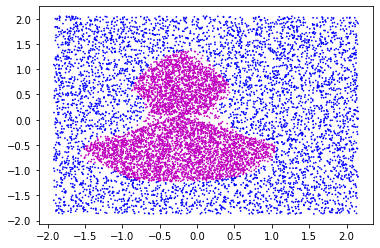

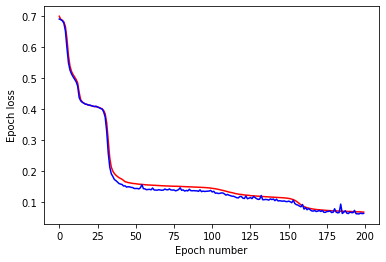

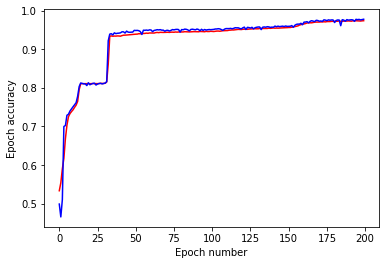

TRAIN:  Epoch:  0  Loss:  0.7001208796373108  Accuracy:  0.5334878516624041
TEST:  Epoch:  0  Loss:  0.6910924042106434  Accuracy:  0.49890525477707004
 
TRAIN:  Epoch:  50  Loss:  0.15919050632897394  Accuracy:  0.9389386189258312
TEST:  Epoch:  50  Loss:  0.14364034184225047  Accuracy:  0.9484474522292994
 
TRAIN:  Epoch:  100  Loss:  0.1443024998068657  Accuracy:  0.9461516943734015
TEST:  Epoch:  100  Loss:  0.13252556875680283  Accuracy:  0.9510350318471338
 
TRAIN:  Epoch:  150  Loss:  0.11164299413190244  Accuracy:  0.9562619884910486
TEST:  Epoch:  150  Loss:  0.10290549321776363  Accuracy:  0.9593949044585988
 
Train accuracy mean:  0.9737651854219949
Train accuracy std:  0.0
Test accuracy mean:  0.9776074840764332
Test accuracy std:  0.0


In [ ]:
import matplotlib.pyplot as plt
final_test_acc = []
final_train_acc = []
# Ensemble prediction
for seed in [420]:
  torch.cuda.manual_seed(seed)
  # model = MLP2(2)
  model = LocallyConnectedMLP(n_layers=4, 
                              activation_fn=nn.Sigmoid(), 
                              input_dim=[10,10,10,10], 
                              output_dim=[10,10,10,1], 
                              kernel_size=[2,2,2,10], 
                              stride=[1,1,1,1])
  if gpu_boole:
    model.cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss = BCELoss()
  # Initialize weights
  if isinstance(model, nn.Linear):
    torch.nn.init.xavier_normal_(model.weight)
  # Record GPU runtime
  if gpu_boole:
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
  # Train
  epoch_losses, epoch_accuracies, epoch_test_losses, epoch_test_accuracies = train(model=model, loss=loss, optimizer=optimizer)
  final_train_acc.append(epoch_accuracies[-1])
  final_test_acc.append(epoch_test_accuracies[-1])
  # Print time
  if gpu_boole:
    end.record()
    torch.cuda.synchronize()
    print('Minutes elapsed: ', start.elapsed_time(end)/60000)

  for i in range(len(epoch_losses)):
    if i % 50 == 0 or i == 499:
      print('TRAIN: ', 'Epoch: ', i, ' Loss: ', epoch_losses[i], ' Accuracy: ', epoch_accuracies[i])
      print('TEST: ', 'Epoch: ', i, ' Loss: ', epoch_test_losses[i], ' Accuracy: ', epoch_test_accuracies[i])
      print(' ')

print('Train accuracy mean: ', np.mean(np.array(final_train_acc)))
print('Train accuracy std: ', np.std(np.array(final_train_acc)))
print('Test accuracy mean: ', np.mean(np.array(final_test_acc)))
print('Test accuracy std: ', np.std(np.array(final_test_acc)))

In [ ]:
# 1C define the model
class MLP2(nn.Module):
  def __init__(self, input_size):
    super(MLP2, self).__init__()

    self.layer1 = nn.Linear(input_size, 16)
    self.layer2 = nn.Linear(16, 8)
    self.layer3 = nn.Linear(8, 4)
    self.layer4 = nn.Linear(4, 1)
    self.sigmoid = Sigmoid()

  def forward(self, x):
    hidden1 = self.layer1(x)
    h1 = self.sigmoid(hidden1)
    hidden2 = self.layer2(h1)
    h2 = self.sigmoid(hidden2)
    hidden3 = self.layer3(h2)
    h3 = self.sigmoid(hidden3)
    out = self.layer4(h3)
    out = self.sigmoid(out)

    return out

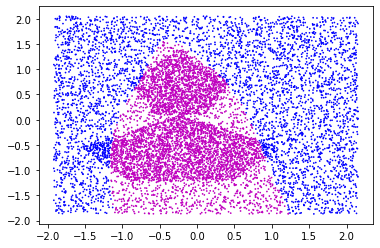

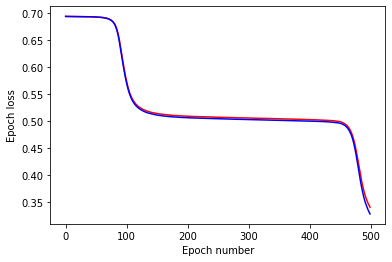

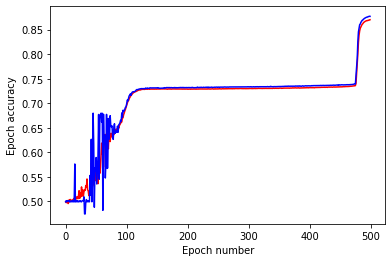

Minutes elapsed:  13.085898958333333
TRAIN:  Epoch:  0  Loss:  0.6935515533322874  Accuracy:  0.49948049872122763
TEST:  Epoch:  0  Loss:  0.6931800880249898  Accuracy:  0.49890525477707004
 
TRAIN:  Epoch:  50  Loss:  0.6922284027042291  Accuracy:  0.5693534207161125
TEST:  Epoch:  50  Loss:  0.6921596644790309  Accuracy:  0.5892714968152867
 
TRAIN:  Epoch:  100  Loss:  0.5723059470086451  Accuracy:  0.6955123081841432
TEST:  Epoch:  100  Loss:  0.5689659762154718  Accuracy:  0.6986464968152867
 
TRAIN:  Epoch:  150  Loss:  0.5134206993881699  Accuracy:  0.7289402173913043
TEST:  Epoch:  150  Loss:  0.5105377500224265  Accuracy:  0.7314888535031847
 
TRAIN:  Epoch:  200  Loss:  0.5084734275517866  Accuracy:  0.7285805626598465
TEST:  Epoch:  200  Loss:  0.5055444578456271  Accuracy:  0.7317874203821656
 
TRAIN:  Epoch:  250  Loss:  0.5064864966189465  Accuracy:  0.7292399296675192
TEST:  Epoch:  250  Loss:  0.5036370205651423  Accuracy:  0.7327826433121019
 
TRAIN:  Epoch:  300  Loss

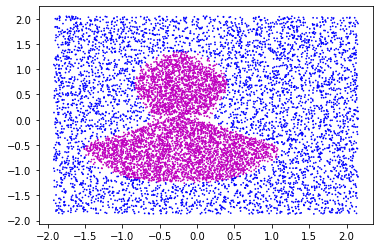

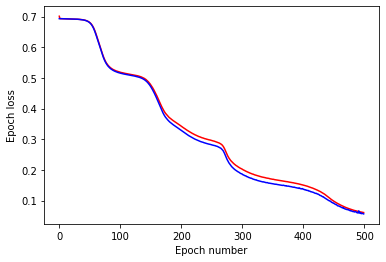

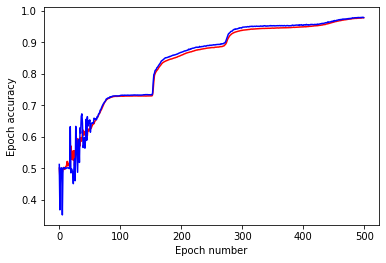

Minutes elapsed:  12.957044791666666
TRAIN:  Epoch:  0  Loss:  0.7013481476575213  Accuracy:  0.5004995204603581
TEST:  Epoch:  0  Loss:  0.6935719726191965  Accuracy:  0.5119426751592356
 
TRAIN:  Epoch:  50  Loss:  0.680887729158182  Accuracy:  0.622582320971867
TEST:  Epoch:  50  Loss:  0.6800001377512694  Accuracy:  0.6532643312101911
 
TRAIN:  Epoch:  100  Loss:  0.5185952014325524  Accuracy:  0.7284806585677749
TEST:  Epoch:  100  Loss:  0.5157224628955696  Accuracy:  0.730593152866242
 
TRAIN:  Epoch:  150  Loss:  0.47735765957466475  Accuracy:  0.7294597186700768
TEST:  Epoch:  150  Loss:  0.47140411909218805  Accuracy:  0.7327826433121019
 
TRAIN:  Epoch:  200  Loss:  0.3425684476371311  Accuracy:  0.8582560741687979
TEST:  Epoch:  200  Loss:  0.32876988419681596  Accuracy:  0.8674363057324841
 
TRAIN:  Epoch:  250  Loss:  0.29589597609303797  Accuracy:  0.8828524616368286
TEST:  Epoch:  250  Loss:  0.2821068743801421  Accuracy:  0.8903264331210191
 
TRAIN:  Epoch:  300  Loss:

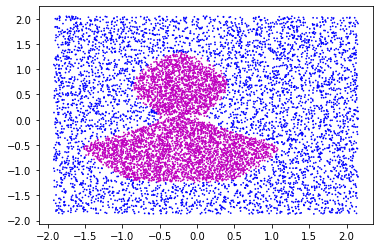

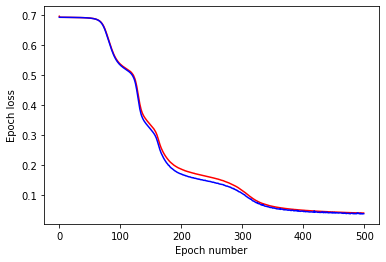

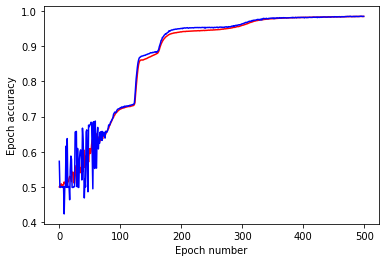

Minutes elapsed:  12.908648958333334
TRAIN:  Epoch:  0  Loss:  0.6965615008493213  Accuracy:  0.5003396739130435
TEST:  Epoch:  0  Loss:  0.6930987948824645  Accuracy:  0.5730493630573248
 
TRAIN:  Epoch:  50  Loss:  0.690534295938204  Accuracy:  0.6088554987212276
TEST:  Epoch:  50  Loss:  0.6903985647638892  Accuracy:  0.6761544585987261
 
TRAIN:  Epoch:  100  Loss:  0.5366733254069258  Accuracy:  0.7210877557544757
TEST:  Epoch:  100  Loss:  0.5333197388299711  Accuracy:  0.725218949044586
 
TRAIN:  Epoch:  150  Loss:  0.3329979547530489  Accuracy:  0.8705642583120204
TEST:  Epoch:  150  Loss:  0.3183836162469949  Accuracy:  0.8816679936305732
 
TRAIN:  Epoch:  200  Loss:  0.18571902826771408  Accuracy:  0.9405570652173914
TEST:  Epoch:  200  Loss:  0.1692198619815954  Accuracy:  0.950437898089172
 
TRAIN:  Epoch:  250  Loss:  0.15775343172175957  Accuracy:  0.9461716751918159
TEST:  Epoch:  250  Loss:  0.14309648322356736  Accuracy:  0.9532245222929936
 
TRAIN:  Epoch:  300  Loss: 

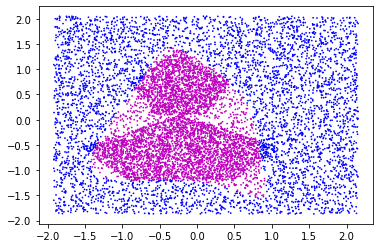

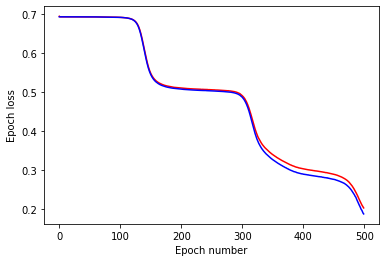

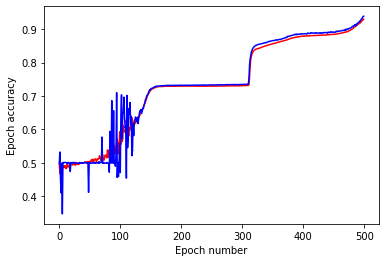

Minutes elapsed:  13.247375
TRAIN:  Epoch:  0  Loss:  0.6947649281348109  Accuracy:  0.4970428388746803
TEST:  Epoch:  0  Loss:  0.693312474496805  Accuracy:  0.49890525477707004
 
TRAIN:  Epoch:  50  Loss:  0.6930867339796423  Accuracy:  0.5044157608695652
TEST:  Epoch:  50  Loss:  0.6930918526497616  Accuracy:  0.49890525477707004
 
TRAIN:  Epoch:  100  Loss:  0.6919440138522926  Accuracy:  0.584698689258312
TEST:  Epoch:  100  Loss:  0.69189874685494  Accuracy:  0.4707404458598726
 
TRAIN:  Epoch:  150  Loss:  0.5477350790558568  Accuracy:  0.7171115728900256
TEST:  Epoch:  150  Loss:  0.5445375917064157  Accuracy:  0.7216361464968153
 
TRAIN:  Epoch:  200  Loss:  0.5100337261205439  Accuracy:  0.7297794117647058
TEST:  Epoch:  200  Loss:  0.5071775960694452  Accuracy:  0.7322850318471338
 
TRAIN:  Epoch:  250  Loss:  0.5057412969029468  Accuracy:  0.729539641943734
TEST:  Epoch:  250  Loss:  0.5028009017941298  Accuracy:  0.7328821656050956
 
TRAIN:  Epoch:  300  Loss:  0.490421852

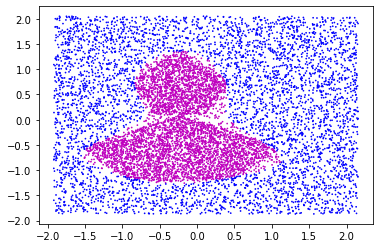

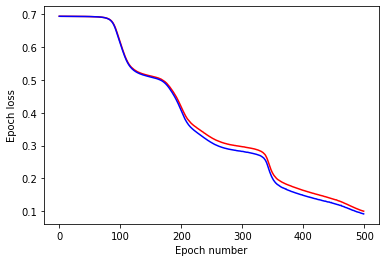

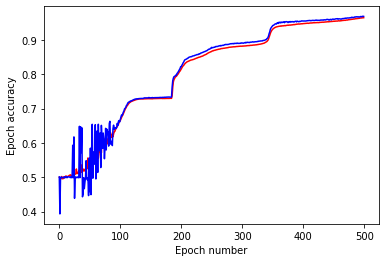

Minutes elapsed:  13.637017708333333
TRAIN:  Epoch:  0  Loss:  0.6933459852205213  Accuracy:  0.500059942455243
TEST:  Epoch:  0  Loss:  0.6931864357298347  Accuracy:  0.50109474522293
 
TRAIN:  Epoch:  50  Loss:  0.6924604146224459  Accuracy:  0.5501118925831202
TEST:  Epoch:  50  Loss:  0.692408838089864  Accuracy:  0.4580015923566879
 
TRAIN:  Epoch:  100  Loss:  0.613266678303099  Accuracy:  0.6651015025575447
TEST:  Epoch:  100  Loss:  0.6101413380568195  Accuracy:  0.6687898089171974
 
TRAIN:  Epoch:  150  Loss:  0.5115919981313788  Accuracy:  0.7287404092071611
TEST:  Epoch:  150  Loss:  0.5085750349388001  Accuracy:  0.7312898089171974
 
TRAIN:  Epoch:  200  Loss:  0.41691554099550027  Accuracy:  0.8161964514066496
TEST:  Epoch:  200  Loss:  0.40570132747577253  Accuracy:  0.8220541401273885
 
TRAIN:  Epoch:  250  Loss:  0.32357042522915186  Accuracy:  0.8669677109974424
TEST:  Epoch:  250  Loss:  0.3085553391723876  Accuracy:  0.8783837579617835
 
TRAIN:  Epoch:  300  Loss:  0

In [ ]:
final_test_acc = []
final_train_acc = []
# Ensemble prediction
for seed in [345, 45, 21, 7.8, 666]:
  torch.cuda.manual_seed(seed)
  mlp = MLP2(input_size=2)
  if gpu_boole:
    mlp.cuda()
  optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
  loss = BCELoss()
  # Initialize weights
  if isinstance(model, nn.Linear):
    torch.nn.init.xavier_normal_(model.weight)
  # Record GPU runtime
  if gpu_boole:
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
  # Train
  epoch_losses, epoch_accuracies, epoch_test_losses, epoch_test_accuracies = train(model=mlp, loss=loss, optimizer=optimizer)
  final_train_acc.append(epoch_accuracies[-1])
  final_test_acc.append(epoch_test_accuracies[-1])
  # Print time
  if gpu_boole:
    end.record()
    torch.cuda.synchronize()
    print('Minutes elapsed: ', start.elapsed_time(end)/60000)

  for i in range(len(epoch_losses)):
    if i % 50 == 0 or i == 499:
      print('TRAIN: ', 'Epoch: ', i, ' Loss: ', epoch_losses[i], ' Accuracy: ', epoch_accuracies[i])
      print('TEST: ', 'Epoch: ', i, ' Loss: ', epoch_test_losses[i], ' Accuracy: ', epoch_test_accuracies[i])
      print(' ')

print('Train accuracy mean: ', np.mean(np.array(final_train_acc)))
print('Train accuracy std: ', np.std(np.array(final_train_acc)))
print('Test accuracy mean: ', np.mean(np.array(final_test_acc)))
print('Test accuracy std: ', np.std(np.array(final_test_acc)))

## Results

Compared to an MLP with fully connected layers, the one with locally connected layers outperforms by approximately 3% on average with a mean accuracy of around 97% for both training and testing. 